In [568]:
import numpy
from data.data_utils import load_dataset



In [569]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.linalg import svd
from pdb import set_trace

# Q1

## Useful functions

In [570]:
# Get RMSE
def RMSE(y, y_hat):
  return np.sqrt(np.mean(np.square(y-y_hat)))

In [571]:
np.random.seed(42)
def knn_regressor(x_train, y_train, x_test, k = 1, metric = "minkowski_2") -> np.array:
    y_test = np.zeros((x_test.shape[0], 1))
    # print(y_test.shape)
    for i, x_test_i in enumerate(x_test):
        if metric == "minkowski_2":
          dist = np.sqrt(np.sum(np.square(x_train-x_test_i.reshape((1,-1))), axis=1))
        elif metric == "minkowski_1":
          dist = np.sum(np.abs(x_train-x_test_i.reshape((1,-1))), axis=1)
        else:
            pass
        i_nn = np.argpartition(dist, kth=k, axis=0)[:k]
        # k=5: i_nn=[122 384  90 399  40] etc
        # compute the mean of these nearest neighbours
        y_test[i,0] = np.mean(y_train[i_nn, 0])
    # y_test: [[mean y for x_test_1], [mean y for x_test_2], [mean y for x_test_3]] ...
    return y_test

def knn_cross_validation(x, y, x_test, dataset, v = 5, metrics = "minkowski_2") -> np.array:
    """
    Cross validation to find the y_test,
    Return k_vals, best, fold_i[np.argmin(best)], k_merged_prediction
    k_vals : list of all k we tried
    best : list of lowest RMSE for each k values
    fold_i[np.argmin(best)] : the fold index with the lowest RMSE value
    k_merged_prediction : predictions merged from cross-validation for each k value
    """
    # Create shuffling indices for training data
    n = x.shape[0]

    # Initialize mrse returned array
    rmse = []
    # rmse[:] = np.nan
    # print(type(mrse))

    # Create random k value
    min_k = dict(rosenbrock=1,  pumadyn32nm=22, mauna_loa=1)  # specify minimum k value to consider in the search
    max_k = dict(rosenbrock=10, pumadyn32nm=26, mauna_loa=30) # specify maximum k value to consider in the search
    # Define a range of k
    k_vals = np.arange(min_k[dataset], max_k[dataset]+1, dtype=int)
    # print(k_vals)
    
    # print("predictions", predictions.shape)
    for k in k_vals:
        predictions = np.zeros(n)
        # predictions[:] = np.nan
        val_err_in_fold = []
        # val_err_in_fold[:] = np.nan
        five_fold = np.array([0,1,2,3,4])
        for i_split in range(v):
            train_fold = np.delete(five_fold, i_split)
            print("train_fold", train_fold)
            # Initialize prediction array
            idx_cv = -np.ones(int(5*np.ceil(n/5)), dtype=int) # round up to the nearest factor of 5
            idx_cv[:n] = np.arange(x.shape[0], dtype=int) # add the indicies of all points
            idx_cv = np.random.permutation(idx_cv).reshape((5, -1))
            idx_cv = idx_cv[idx_cv>=0]
            idx_cv = np.array_split(idx_cv, 5)
            # print("k: %d; fold: %d; idx_cv:"%(k, i_split))
            # print(idx_cv)
            split_train = np.concatenate([idx_cv[i] for i in train_fold])
            
            split_valid = idx_cv[i_split]
            print("len:", len(split_train), len(split_valid))

            
            # split_valid = idx_cv[i_split, idx_cv[i_split] >= 0]
            # split_train = np.delete(idx_cv, i_split, axis=0).reshape(-1)
            # split_train = split_train[split_train >= 0]

            x_valid = x[split_valid]
            # print("split valid", len(split_valid))
            # print("y", y.shape)
            y_valid = y[split_valid]
            # print("k", k)
            # print("split valid", split_valid)
            # print("split train", split_train)
            # print("x", x[split_train])
            predictions[split_valid] = knn_regressor(x_train=x[split_train], y_train=y[split_train], 
                                                        x_test=x_valid, k=k, metric=metrics).squeeze()
            # print("dim valid", y_valid.squeeze().shape)
            # print("dim pred", predictions.shape)
            val_err = RMSE(y=y_valid.squeeze(), y_hat=predictions[split_valid])
            # print("k: %d; fold: %d; RMSE: %f "%(k, i_split, val_err))
            val_err_in_fold.append(val_err)
        # print("k", k, val_err_in_fold)
        rmse.append(val_err_in_fold)
    print("mse", np.asarray(rmse))
    rmse = np.asarray(rmse)
    fold_i = rmse.argmin(axis=1)
    best = rmse.min(axis=1)
    # print("best",best)
    return k_vals, best, fold_i[np.argmin(best)]

## Mauna Loa

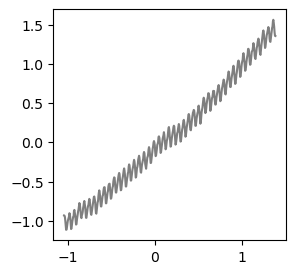

In [572]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mauna_loa')
# Merge splits
x = np.vstack([x_valid, x_train])
y = np.vstack([y_valid, y_train])

# Visualize our data
plt.figure(figsize=(3,3))
plt.plot(x_train.squeeze(), y_train.squeeze(), 'k', label='Exact', alpha=0.5)

In [573]:
# Shuffle
# idx = np.ones(x.shape[0])
idx = np.arange(x.shape[0], dtype=int)
idx = np.random.permutation(idx)
idx = np.array_split(idx, 5)
len(idx[4])

131

In [574]:
np.random.seed(42)
# Split the data
x_train_folds = np.array_split(x, 5)
y_train_folds = np.array_split(y, 5)

In [575]:
a = [1,2,3]
b = np.array([[4],[5],[6],[7]])
bb = np.zeros((y.shape[0], 1))

for i in range(bb.shape[0]):
    bb[i,0]=np.mean(y_train[b, 0])

b[1,0]

5

In [576]:
k_vals, best2, fold_2 = knn_cross_validation(x, y, x_test, "mauna_loa", v = 5, metrics = "minkowski_2")

plt.figure()
plt.title('validation errors across k (L2 distance metric)')
plt.xlabel('k')
plt.plot(k_vals, best2)

# print(k_vals,best2,fold_2)


train_fold [1 2 3 4]
len: 524 132


ValueError: operands could not be broadcast together with shapes (132,) (656,) 

In [ ]:
# rmse = [[1,2,3],[4,5,6]]
# rmse_max = [max(r) for r in rmse]
# rmse_max

In [ ]:
_, best1, fold_1 = knn_cross_validation(x, y, x_test, "mauna_loa", v = 5, metrics = "minkowski_1")
# best = [ err * 30 ]
# Show validation errors for both metrics
plt.figure()
plt.title('validation errors across k (L2 distance metric)')
plt.xlabel('k')
plt.plot(k_vals, best2, label = "l2")
plt.plot(k_vals, best1, label = "l1")
plt.legend()
plt.show()

In [ ]:
# Plot Prediction Curves for several k values
y_k1 = knn_regressor(x, y, x_test, k = 1, metric = "minkowski_2")

plt.figure(figsize=(7,7))
plt.title('Predictions on Testing Data for Mauna Loa')
plt.ylabel('y')
plt.xlabel('x_test')
plt.plot(x.squeeze(), y.squeeze(), label='Exact', alpha=0.5)
plt.plot(x_test.squeeze(), .squeeze(), label='Predictions', alpha=0.5)
plt.legend()
plt.show()

In [ ]:
idx1 = np.argmin(best1)
idx2 = np.argmin(best2)
p = np.argmin([best1[idx1], best2[idx2]]) + 1
if p == 2:
    k = idx2+1
    print("Metric Minkowski with p = %d at k = %d %dth fold has the lowest validation error %f." %(p, k, fold_2+1, best2[idx2]))
else:
    k = idx1+1
    print("Metric Minkowski with p = %d at k = %d %dth fold has the lowest validation error %f." %(p, k, fold_1+1, best1[idx1]))

# Find test error
def k_nn_test_error(x_train, y_train, x_test, y_test, k, metric) -> np.array:
    predictions = knn_regressor(x_train=x_train, y_train=y_train, 
                                                        x_test=x_test, k=k, metric=metric).squeeze()
            # print(predictions)
            # print("dim valid", y_valid.squeeze().shape)
            # print("dim pred", predictions.shape)
    test_err = RMSE(y=y_test.squeeze(), y_hat=predictions)
    
    return predictions, test_err
m = "minkowski_" + str(p)
predictions, test_err = k_nn_test_error(x, y, x_test, y_test, k = k, metric = m)
print("The test error for the best model is: %f" %(test_err))
test_err


In [ ]:
x_valid.shape

In [ ]:
# Visualize our data
plt.figure(figsize=(7,7))
plt.title('Predictions on Testing Data for Mauna Loa')
plt.ylabel('y')
plt.xlabel('x_test')
plt.plot(x.squeeze(), y.squeeze(), label='Exact', alpha=0.5)
plt.plot(x_test.squeeze(), predictions.squeeze(), label='Predictions', alpha=0.5)
plt.legend()
plt.show()

## Rosenbrock, n_train=1000, d=2

In [ ]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('rosenbrock', n_train=1000, d=2)


In [ ]:
# Merge splits
x = np.vstack([x_valid, x_train])
y = np.vstack([y_valid, y_train])

# # Visualize our data
# plt.figure(figsize=(3,3))
# plt.plot(x_train.squeeze(), y_train.squeeze(), 'k', label='Exact', alpha=0.5)

In [ ]:
_, best1, fold_1 = knn_cross_validation(x, y, x_test, "rosenbrock", v = 5, metrics = "minkowski_1")
_, best1, fold_1 = knn_cross_validation(x, y, x_test, "rosenbrock", v = 5, metrics = "minkowski_1")

In [ ]:
plt.figure()
plt.title('validation errors across k (L2 distance metric)')
plt.xlabel('k')
plt.plot(k_vals, best2)
